In [10]:
import math
from numbers import Number
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from tools.index_sensitivity import IndexSensitivity
from tools.sound_processor import SoundProcessor as sp
from tools import plots


In [11]:
def add_call_to_signal(signal, frequency, fs, duration):
    mulloway = sp.create_sine(frequency, duration, fs, amp=1)
    mulloway_len = len(mulloway.signal)
    interval = math.ceil(duration * fs)
    call_on = True
    sig_len = len(signal)
    for pos in range(0, sig_len, interval):
        if call_on:
            if pos + mulloway_len >= sig_len:
                mulloway.signal = mulloway.signal[:sig_len - pos]

            signal[pos:pos+mulloway_len] += mulloway.signal

        call_on = not call_on

In [12]:
def spectrogram(signal, fs, window):
    f, t, sxx = sp.create_spectrogram(signal, fs, samples=window, window="hamming")
    if not f[0]: # remove DC componenet
        sxx = sxx[1:] 
        f = f[1:]

    return f, t, sxx

In [13]:
def generate_white_noise(fs, duration, proportion=0.1):
    np.random.seed(0)
    noise = np.random.normal(0, 1, fs * duration)
    noise = noise / np.max(np.abs(noise))
    noise *= proportion

    return noise

In [14]:
def create_varying_frequency_waves(duration, interval, fs, freqs, white=None):
    if white is None:
        white = generate_white_noise(fs, duration)

    waves = []
    for freq in freqs:
        sound = np.copy(white)
        add_call_to_signal(sound, freq, fs, interval)
        waves.append(sound)

    return waves

In [15]:
def create_varying_interval_waves(duration, frequency, fs, intervals, white=None):
    if white is None:
        white = generate_white_noise(fs, duration)

    waves = []
    for interval in intervals:
        sound = np.copy(white)
        add_call_to_signal(sound, frequency, fs, interval)
        waves.append(sound)

    return waves

In [16]:
def calculate_vals_from_window_list(lst, func):
    ret = []
    for collection in lst:
        vals = []
        for sxx, f in collection:
            val = func(sxx, f)
            vals.append(val)

        ret.append(vals)

    return ret

In [17]:
def plot_idx_values(vals, lgd_vals, fft_windows, idx, name, lgd_txt, lgd_title="Legend", set_ttl=False):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    decimals = False
    for i, val in enumerate(lgd_vals):
        if isinstance(val, float): decimals = True
        if isinstance(val, Number):
            val = f"{val:,.2f} {lgd_txt}" if decimals else f"{val:,d} {lgd_txt}"

        ax.plot(fft_windows, vals[i], label=val, color=plots.default_color_scheme[i])

    ax.set_xlabel(f"FFT window size (samples)")
    ax.set_ylabel(idx)
    lgd = ax.legend(title=lgd_title, loc='center left', bbox_to_anchor=(1,0.5))
    if set_ttl:
        ttl = ax.set_title(f"{idx} {name}")
        extra = (lgd, ttl,)
    else:
        extra = (lgd,)

    plots.save_plt_fig(fig, f"output/{idx}_{name}_rate_plot", bbox_extra_artists=extra, tight=True, ext="png")

    return fig

ACI


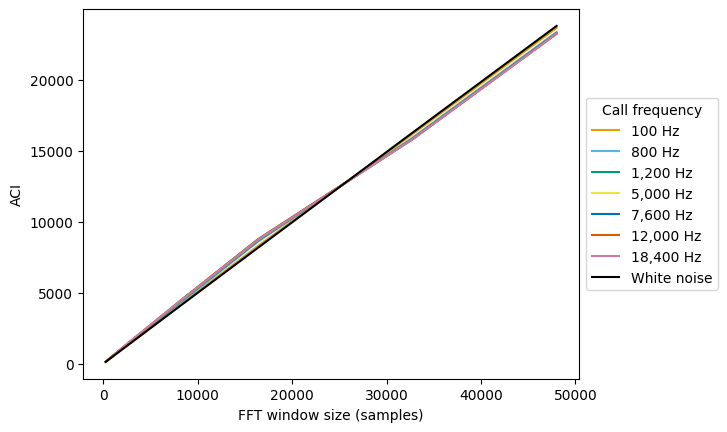

ACI


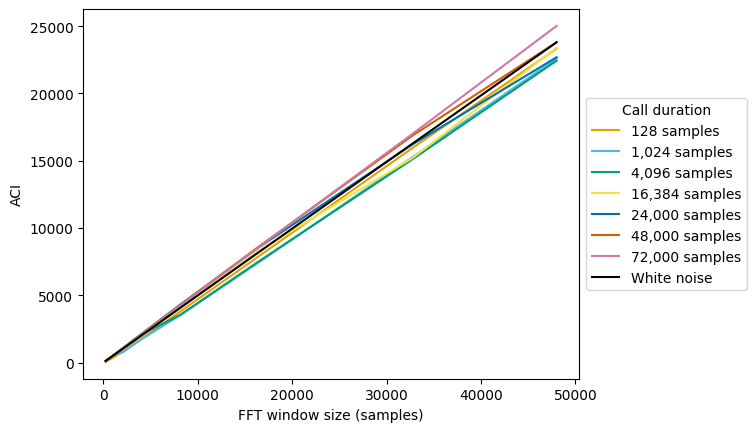

ADI


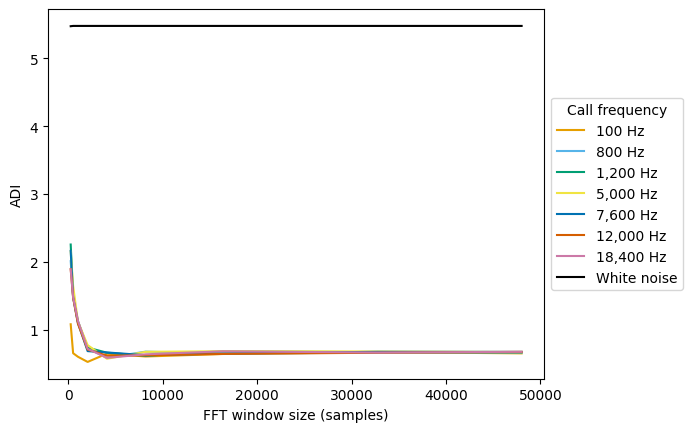

ADI


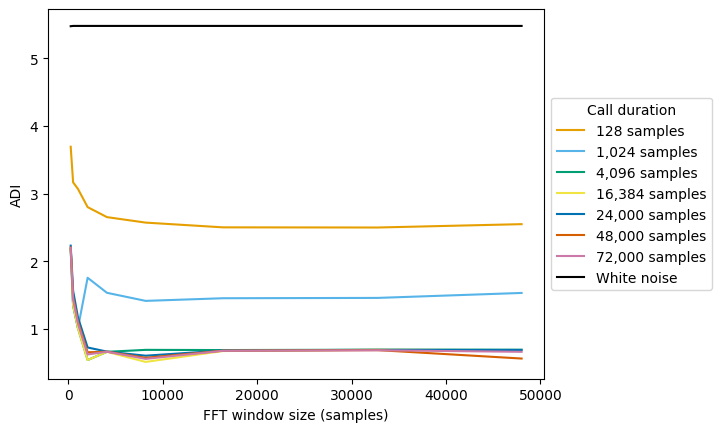

AEI


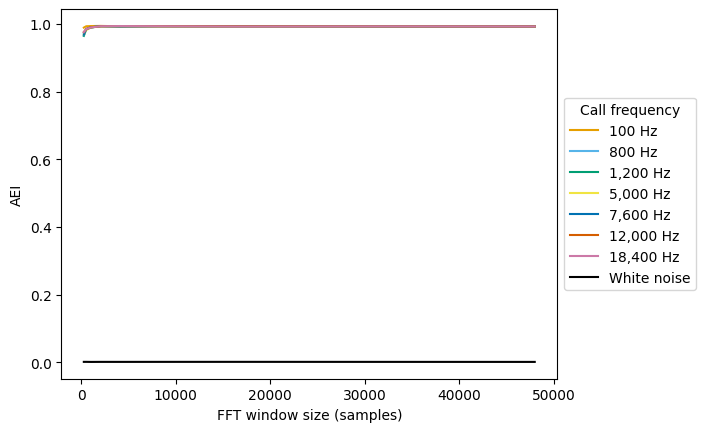

AEI


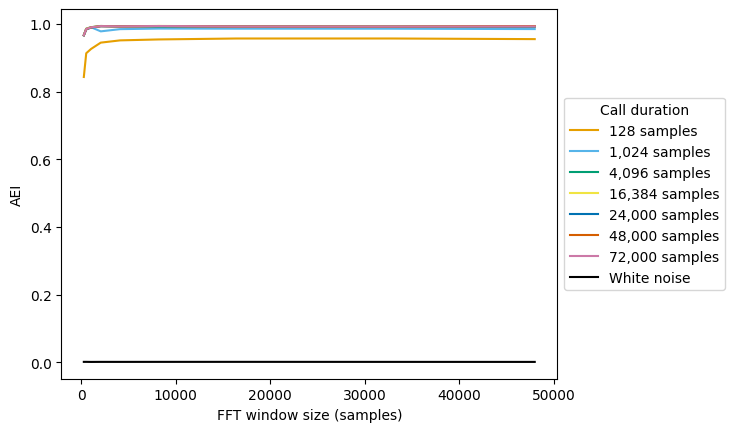

BIO


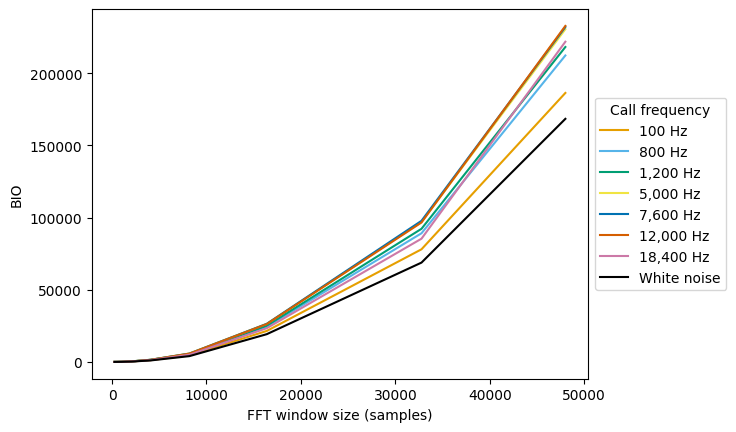

BIO


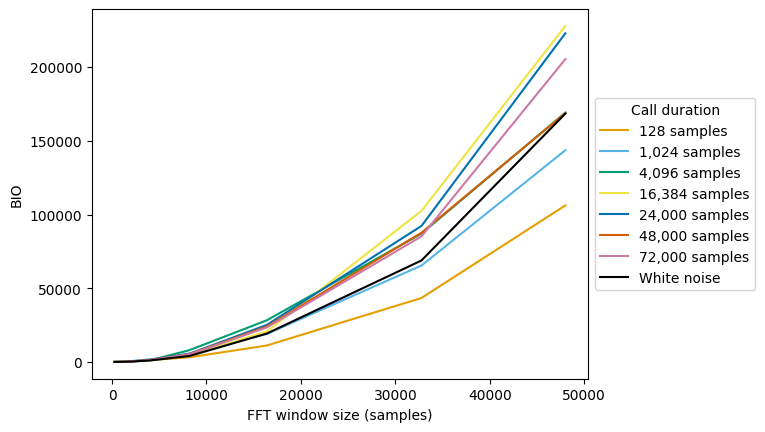

In [18]:
fs = 48000
two_mins_s = 60 * 2
fft_windows = [2**x for x in range(8, 16)] + [fs]
call_freqs = [100, 800, 1200, 5000, 7600, 12000, 18400]
call_intervals = [128 / fs, 1024 / fs, 4096 / fs, 2**14 / fs, 0.5, 1, 1.5]

spectrograms = {"White noise": [], "Frequency": [], "Interval": []}
white_noise = generate_white_noise(fs, two_mins_s)
varying_frequency_waves = create_varying_frequency_waves(120, 0.6, fs, call_freqs, white_noise)
varying_interval_waves = create_varying_interval_waves(120, 1000, fs, call_intervals, white_noise)
for name, lst in [("White noise", [white_noise]), 
                    ("Frequency", varying_frequency_waves),
                    ("Interval", varying_interval_waves)]:
    for wave in lst:
        wave_lst = []
        for window in fft_windows:
            f, _, sxx = spectrogram(wave, fs, window)
            wave_lst.append((sxx, f))

        spectrograms[name].append(wave_lst)
    
for idx in ["ACI", "ADI", "AEI", "BIO"]:
    func = IndexSensitivity.get_index_func(idx)
    white_noise_vals = calculate_vals_from_window_list(spectrograms["White noise"], func)
    for key, lgd, txt, ttl in [("Frequency", call_freqs, "Hz", "Call frequency"), 
                                ("Interval", [int(x * fs) for x in call_intervals], "samples", "Call duration")]:
        varying = calculate_vals_from_window_list(spectrograms[key], func)
        fig = plot_idx_values(varying+white_noise_vals, 
                        lgd+["White noise"], 
                        fft_windows, idx, f"call {key.lower()} effect", txt, ttl, set_ttl=False)

        print(idx)
        display(fig)